In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

from lesson_functions import *

from sklearn.cross_validation import train_test_split

from sklearn.externals import joblib
from scipy.ndimage.measurements import label

/Users/kkanjanapas/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Step 1: Data Exploration

Cars data size = 8792 
Not Cars data size = 8968


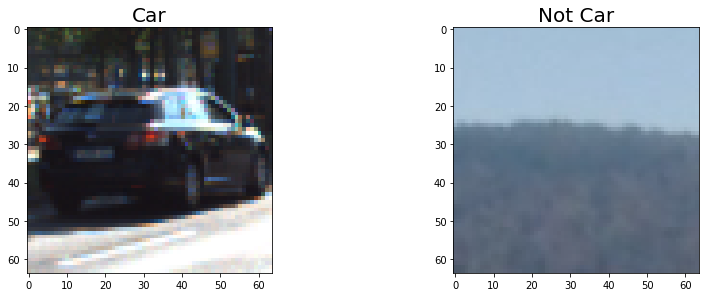

In [2]:
cars = []
notcars = []

# cars
images = glob.iglob('vehicles/**/*.png')  # cars
for image in images:
    cars.append(image)

# non-cars
images = glob.iglob('non-vehicles/**/*.png')  # noncars
for image in images:
    notcars.append(image)

ind_car = np.random.randint(0, len(cars))
ind_notcars = np.random.randint(0, len(notcars))

print('Cars data size = %.0f \nNot Cars data size = %.0f' % (len(cars), len(notcars)))

ind_plot = 1
if (ind_plot):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    f.tight_layout()
    ax1.imshow(mpimg.imread(cars[ind_car]))
    ax1.set_title('Car', fontsize=20)
    ax2.imshow(mpimg.imread(notcars[ind_notcars]))
    ax2.set_title('Not Car', fontsize=20)
    plt.show()


# Step 2: Feature Extraction

In [3]:
# Parameters for feature extraction

colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb

use_spatial = 1
spatial_size = (32,32)

use_hist = 1
hist_bins = 32

use_hog = 1
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

# --------------------------------------------------------------------------------
t=time.time()

car_features = extract_features(cars, color_space=colorspace , spatial_size=spatial_size,
                     hist_bins=hist_bins, orient=orient,
                     pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                     spatial_feat=use_spatial, hist_feat=use_hist, hog_feat=use_hog)

notcar_features = extract_features(notcars, color_space=colorspace , spatial_size=spatial_size,
                     hist_bins=hist_bins, orient=orient,
                     pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                     spatial_feat=use_spatial, hist_feat=use_hist, hog_feat=use_hog)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

/Users/kkanjanapas/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


79.01 Seconds to extract features...


/Users/kkanjanapas/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


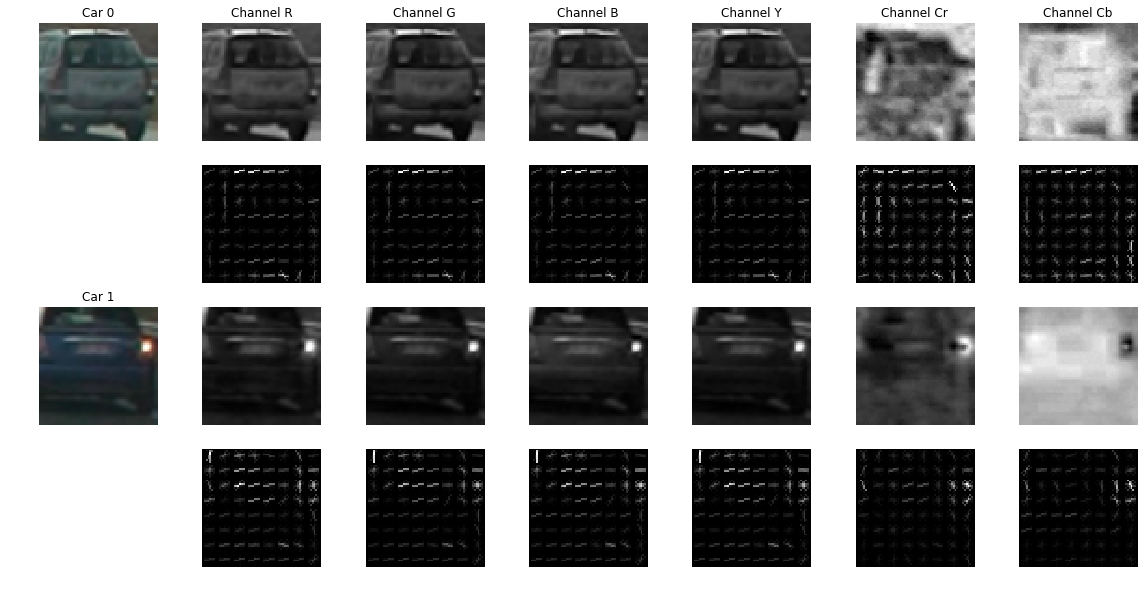

In [5]:
fig, axes = plt.subplots(4, 7, figsize=(20, 10))  # , figsize=(20, 10)
ind_plot = 1
if (ind_plot):
    cars_file = []

    for ii in range(0, 2):

        img = plt.imread(cars[ii])
        cars_file.append(cars[ii])
        color_channel = []
        img_hog_feature = []
        colorspace_vec = np.array(['RGB','YCrCb'])
        for cc in range(2):

            colorspace = colorspace_vec[cc]
            if colorspace != 'RGB':
                if colorspace == 'HSV':
                    color_channel.append(cv2.cvtColor(img, cv2.COLOR_RGB2HSV))
                elif colorspace == 'LUV':
                    color_channel.append(cv2.cvtColor(img, cv2.COLOR_RGB2LUV))
                elif colorspace == 'HLS':
                    color_channel.append(cv2.cvtColor(img, cv2.COLOR_RGB2HLS))
                elif colorspace == 'YUV':
                    color_channel.append(cv2.cvtColor(img, cv2.COLOR_RGB2YUV))
                elif colorspace == 'YCrCb':
                    color_channel.append(cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb))
            else:
                color_channel.append(img)


        axes[2*ii, 0].imshow(img)
        axes[2*ii, 0].axis('off')
        axes[2*ii, 0].set_title('Car {}'.format(ii))

        for jj in range(0, 3):
            axes[2*ii, jj+1].imshow(color_channel[0][:, :, jj], cmap='gray')
            axes[2*ii, jj+1].axis('off')
            #axes[2*ii, jj+1].set_title('RGB Channel {}'.format(jj))

            axes[2*ii, jj+4].imshow(color_channel[1][:, :, jj], cmap='gray')
            axes[2*ii, jj+4].axis('off')
            #axes[2*ii, jj+4].set_title('YUV Channel {}'.format(jj))

        for jj in range(0, 3):
            features, hog_image = get_hog_features(color_channel[0][:, :, jj], orient, pix_per_cell, cell_per_block,
                                                   vis=True, feature_vec=False)
            axes[2*ii+1, jj].axis('off')
            axes[2*ii+1, jj+1].imshow(hog_image, cmap='gray')
            axes[2*ii+1, jj+1].axis('off')
            #axes[2*ii+1, jj+1].set_title('Hog RGB Channel {}'.format(jj))

            features, hog_image = get_hog_features(color_channel[1][:, :, jj], orient, pix_per_cell, cell_per_block,
                                                   vis=True, feature_vec=False)
            axes[2*ii+1, jj+4].imshow(hog_image, cmap='gray')
            axes[2*ii+1, jj+4].axis('off')
            #axes[2*ii+1, jj+4].set_title('Hog YUV Channel {}'.format(jj))
        
        if (ii == 0):
            axes[0, 1].set_title('Channel R')
            axes[0, 2].set_title('Channel G')
            axes[0, 3].set_title('Channel B')
            axes[0, 4].set_title('Channel Y')
            axes[0, 5].set_title('Channel Cr')
            axes[0, 6].set_title('Channel Cb')


plt.show()

/Users/kkanjanapas/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


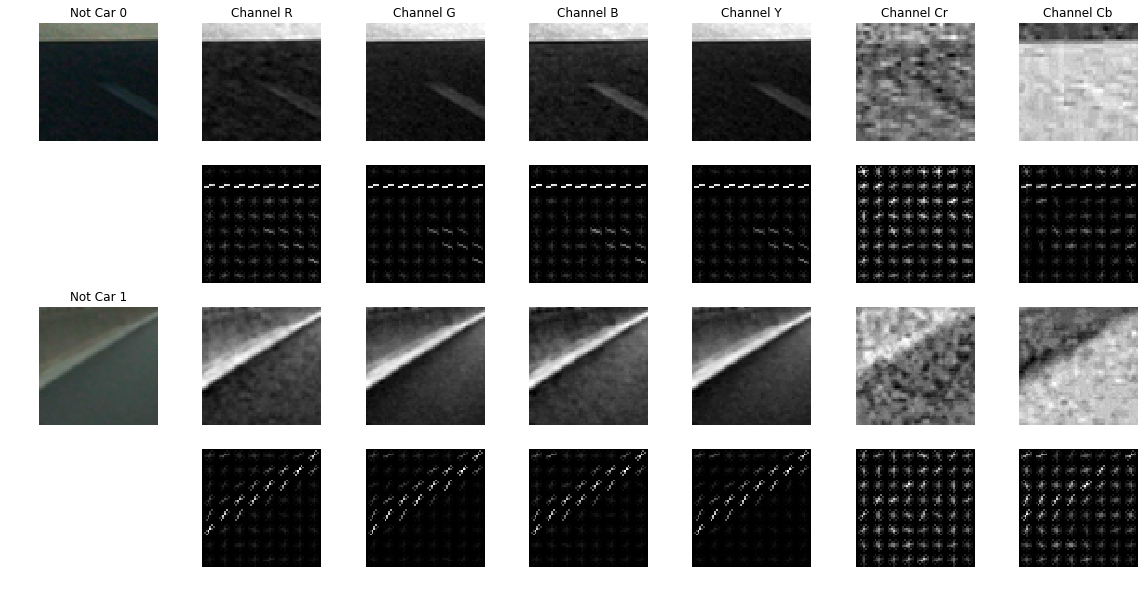

In [6]:
fig, axes = plt.subplots(4, 7, figsize=(20, 10))  # , figsize=(20, 10)
ind_plot = 1
if (ind_plot):
    notcars_file = []

    for ii in range(0, 2):

        img = plt.imread(notcars[ii])
        notcars_file.append(notcars[ii])
        color_channel = []
        img_hog_feature = []
        colorspace_vec = np.array(['RGB','YCrCb'])
        for cc in range(2):

            colorspace = colorspace_vec[cc]
            if colorspace != 'RGB':
                if colorspace == 'HSV':
                    color_channel.append(cv2.cvtColor(img, cv2.COLOR_RGB2HSV))
                elif colorspace == 'LUV':
                    color_channel.append(cv2.cvtColor(img, cv2.COLOR_RGB2LUV))
                elif colorspace == 'HLS':
                    color_channel.append(cv2.cvtColor(img, cv2.COLOR_RGB2HLS))
                elif colorspace == 'YUV':
                    color_channel.append(cv2.cvtColor(img, cv2.COLOR_RGB2YUV))
                elif colorspace == 'YCrCb':
                    color_channel.append(cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb))
            else:
                color_channel.append(img)


        axes[2*ii, 0].imshow(img)
        axes[2*ii, 0].axis('off')
        axes[2*ii, 0].set_title('Not Car {}'.format(ii))

        for jj in range(0, 3):
            axes[2*ii, jj+1].imshow(color_channel[0][:, :, jj], cmap='gray')
            axes[2*ii, jj+1].axis('off')
            #axes[2*ii, jj+1].set_title('RGB Channel {}'.format(jj))

            axes[2*ii, jj+4].imshow(color_channel[1][:, :, jj], cmap='gray')
            axes[2*ii, jj+4].axis('off')
            #axes[2*ii, jj+4].set_title('YUV Channel {}'.format(jj))

        for jj in range(0, 3):
            features, hog_image = get_hog_features(color_channel[0][:, :, jj], orient, pix_per_cell, cell_per_block,
                                                   vis=True, feature_vec=False)
            axes[2*ii+1, jj].axis('off')
            axes[2*ii+1, jj+1].imshow(hog_image, cmap='gray')
            axes[2*ii+1, jj+1].axis('off')
            #axes[2*ii+1, jj+1].set_title('Hog RGB Channel {}'.format(jj))

            features, hog_image = get_hog_features(color_channel[1][:, :, jj], orient, pix_per_cell, cell_per_block,
                                                   vis=True, feature_vec=False)
            axes[2*ii+1, jj+4].imshow(hog_image, cmap='gray')
            axes[2*ii+1, jj+4].axis('off')
            #axes[2*ii+1, jj+4].set_title('Hog YUV Channel {}'.format(jj))
        
        if (ii == 0):
            axes[0, 1].set_title('Channel R')
            axes[0, 2].set_title('Channel G')
            axes[0, 3].set_title('Channel B')
            axes[0, 4].set_title('Channel Y')
            axes[0, 5].set_title('Channel Cr')
            axes[0, 6].set_title('Channel Cb')


plt.show()

# Step 3: Model Training

In [8]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
accuracy = round(svc.score(X_test, y_test), 4)
print('Test Accuracy of SVC = ', accuracy)

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
21.81 Seconds to train SVC...
Test Accuracy of SVC =  0.9885
My SVC predicts:  [ 0.  0.  1.  1.  1.  1.  1.  1.  0.  0.]
For these 10 labels:  [ 0.  0.  1.  1.  1.  1.  1.  1.  0.  0.]
0.00173 Seconds to predict 10 labels with SVC


In [6]:
setting = dict(colorspace=colorspace,
               use_spatial=use_spatial, spatial_size=spatial_size,
               use_hist=use_hist, hist_bins=hist_bins,
               use_hog=use_hog, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
               X=X, X_scaler=X_scaler, scaled_X=scaled_X, y=y, accuracy=accuracy)
joblib.dump({'svc':svc, 'setting':setting}, 'Trained_Models/model0.pkl')

['Trained_Models/model0.pkl']